# Classification of b-quark jets in the Aleph simulated data

Python macro for selecting b-jets (sprays of particles with a b-quark in it) in Aleph Z -> qqbar MC (i.e. simulated decays of the Z0 boson decaying to a quark and an anti-quark) in various ways:
* Initially, simply with "if"-statements making requirements on certain variables. This corresponds to selecting "boxes" in the input variable space (typically called "X"). One could also try a Fisher discriminant (linear combination of input variables), which corresponds to a plane in the X-space. But as the problem is non-linear, it is likely to be sub-optimal.

* Next using Machine Learning (ML) methods. We will during the first week try both (Boosted) Decision Tree ((B)DT) based and Neural Net (NN) based methods, and see how complicated (or not) it is to get a good solution, and how much better it performs compared to the "classic" selection method.

Once you obtain a classification of b-jets vs. non-b-jets, think about how to quantify the quality of your algorithm. Also, try to compare it to the NN result of the Aleph collaboration, given by the variable "nnbjet". It is based on a neural network with 6 input variables (prob_b, spheri, pt2rel, multip, bqvjet, and ptlrel), and two hidden layers each with 10 nodes in. Can you do better?

In the end, this exercise is the simple start on moving into the territory of Machine Learning analysis.


### Data:
The input variables (X) are (where Aleph uses only the first six):
* **prob_b**: Probability of being a b-jet from the pointing of the tracks to the vertex.
* **spheri**: Sphericity of the event, i.e. how spherical it is.
* **pt2rel**: The transverse momentum squared of the tracks relative to the jet axis, i.e. width of the jet.
* **multip**: Multiplicity of the jet (in a relative measure).
* **bqvjet**: b-quark vertex of the jet, i.e. the probability of a detached vertex.
* **ptlrel**: Transverse momentum (in GeV) of possible lepton with respect to jet axis (about 0 if no leptons).
* energy: Measured energy of the jet in GeV. Should be 45 GeV, but fluctuates.
* cTheta: cos(theta), i.e. the polar angle of the jet with respect to the beam axis. Note, that the detector works best in the central region (|cTheta| small) and less well in the forward regions.
* phi:    The azimuth angle of the jet. As the detector is uniform in phi, this should not matter (much).

The target variable (Y) is:
* isb:    1 if it is from a b-quark and 0, if it is not.

Finally, those before you (the Aleph collaboration in the mid 90'ies) produced a Neural Net (6 input variables, two hidden layers with 10 neurons in each, and 1 output varible) based classification variable, which you can compare to (and compete with?):
* nnbjet: Value of original Aleph b-jet tagging algorithm, using only the last six variables (for reference).


### Task:
Thus, the task before you is to produce functions (non-ML and then ML algorithm), which given the input variables X provides an output variable estimate, Y_est, which is "closest possible" to the target variable, Y. The "closest possible" is left to the user to define in a _Loss Function_, which we will discuss further. In classification problems (such as this), the typical loss function to use "Cross Entropy", see https://en.wikipedia.org/wiki/Cross_entropy.

Once you have results, you're welcome to continue with a Fisher Linear Discriminant, and you may also challenge yourself by considering "v1" of the data, which is a little less "polished and ready". If you also manage this, then don't hold back in applying a real ML algorithm to the problem (you can get inspiration from "ML_MethodsDemos.ipynb" or the vast internet). A suggestion might be XGBoost or LightGBM.

* Author: Troels C. Petersen (NBI)
* Email:  petersen@nbi.dk
* Date:   17th of April 2023

In [1]:
from __future__ import print_function, division   # Ensures Python3 printing & division standard
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import numpy as np
import csv
from sklearn.metrics import roc_curve, auc

In [2]:
# setting for plotting
from matplotlib.patches import ConnectionPatch
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
plt.style.use('seaborn-white')
sns.set_style('white', {'legend.frameon':True})
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 14
sns.set_palette("colorblind")
color = sns.color_palette("colorblind")

/var/folders/5c/kvpjh5n11_j2mp3l99c22xdr0000gn/T/ipykernel_1523/787740982.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


Possible other packages to consider:
cornerplot, seaplot, sklearn.decomposition(PCA)

In [3]:
r = np.random
r.seed(42)

SavePlots = False
plt.close('all')

# Evaluate an attempt at classification:

This is made into a function, as this is called many times. It returns a "confusion matrix" and the fraction of wrong classifications.

In [4]:
def evaluate(bquark) :
    N = [[0,0], [0,0]]   # Make a list of lists (i.e. confusion matrix) for counting successes/failures.
    for i in np.arange(len(isb)):
        if (bquark[i] == 0 and isb[i] == 0) : N[0][0] += 1
        if (bquark[i] == 0 and isb[i] == 1) : N[0][1] += 1
        if (bquark[i] == 1 and isb[i] == 0) : N[1][0] += 1
        if (bquark[i] == 1 and isb[i] == 1) : N[1][1] += 1
    fracWrong = float(N[0][1]+N[1][0])/float(len(isb))
    accuracy = 1.0 - fracWrong
    return N, accuracy, fracWrong

# Main program start:

Read in the data, and make arrays of each variable (and understand these!).

In [5]:
# Get data (with this very useful NumPy reader):
data = np.genfromtxt('AlephBtag_MC_train_Nev5000.csv', names=True)    # For faster running
# data = np.genfromtxt('AlephBtag_MC_train_Nev50000.csv', names=True)   # For more data

# Kinematics (energy and direction) of the jet:
energy = data['energy']
cTheta = data['cTheta']
phi    = data['phi']

# Classification variables (those used in Aleph's NN):
prob_b = data['prob_b']
spheri = data['spheri']
pt2rel = data['pt2rel']
multip = data['multip']
bqvjet = data['bqvjet']
ptlrel = data['ptlrel']

# Aleph's Neural Net (NN) score:
nnbjet = data['nnbjet']

# Truth variable whether it really was a b-jet or not (i.e. target)
isb    = data['isb']

# List over features to train on
features = ['prob_b', 'spheri', 'pt2rel', 'multip', 'bqvjet', 'ptlrel']

# Inspect the data:
Define the histogram range and binning (important - programs are generally NOT good at this):

In [6]:
Nbins = 100
xmin = 0.0
xmax = 1.0

### Make new lists selected based on what the jets really are (b-quark jet or light-quark jet):

In [7]:
prob_b_bjets = prob_b[isb == 1]
prob_b_ljets = prob_b[isb == 0]
bqvjet_bjets = bqvjet[isb == 1]
bqvjet_ljets = bqvjet[isb == 0]

### Produce 1D figures:

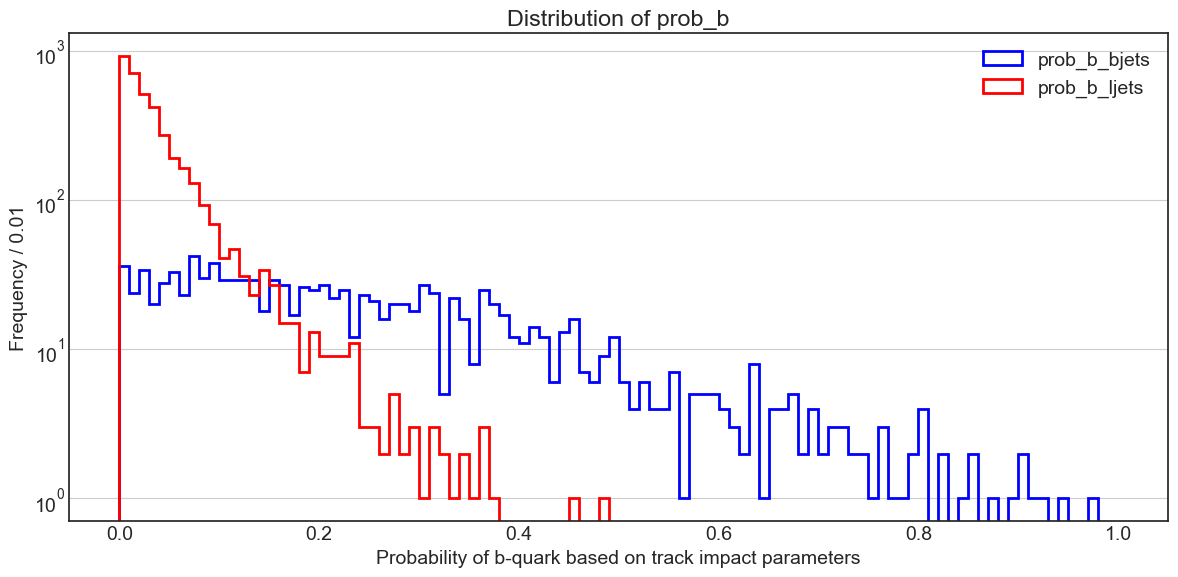

In [8]:
# Produce the actual figure, here with two histograms in it:
fig, ax = plt.subplots(figsize=(12, 6))      # Create just a single figure and axes (figsize is in inches!)
hist_prob_b_bjets = ax.hist(prob_b_bjets, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, label='prob_b_bjets', color='blue')
hist_prob_b_ljets = ax.hist(prob_b_ljets, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, label='prob_b_ljets', color='red')
ax.set_xlabel("Probability of b-quark based on track impact parameters")     # Label of x-axis
ax.set_ylabel("Frequency / 0.01")                                            # Label of y-axis
ax.set_title("Distribution of prob_b")                                       # Title of plot
ax.set_yscale("log")
ax.legend(loc='best')                                                        # Legend. Could also be 'upper right'
ax.grid(axis='y')

fig.tight_layout()
#fig.show()

if SavePlots :
    fig.savefig('Hist_prob_b_and_bqvjet.pdf', dpi=600)

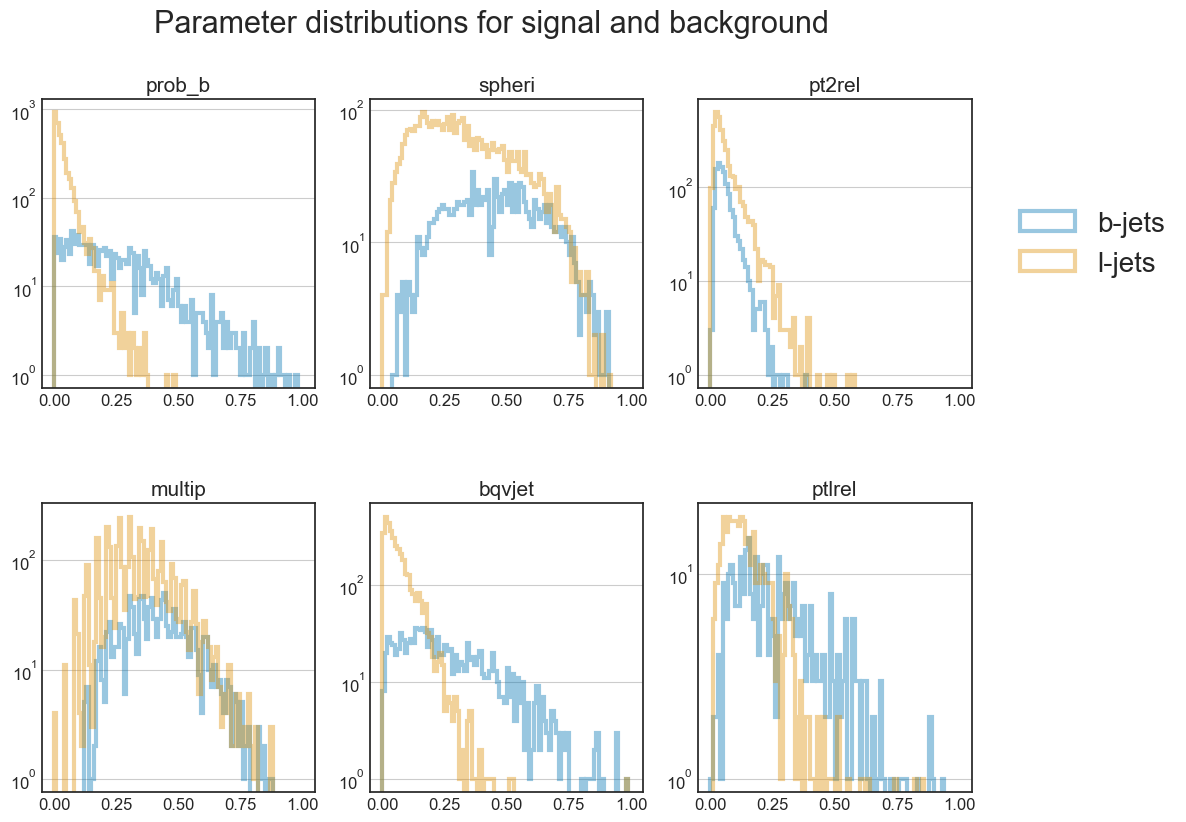

In [9]:
# Show 1D distributions
fig, ax = plt.subplots(nrows=2, ncols=3, gridspec_kw={'wspace':0.2, 'hspace':0.4}, figsize=(12,9))
ax = ax.flatten()

# Loop over features
for i in range(len(features)):
    ax[i].set_title(features[i], fontsize=15)
    ax[i].tick_params(axis="x", labelsize=12) 
    ax[i].tick_params(axis="y", labelsize=12) 
    ax[i].set_yscale("log")
    ax[i].grid(axis='y')
    
    _, bins_arr, _ = ax[i].hist(data[features[i]][isb == 1], bins=Nbins, range=(xmin, xmax), zorder=2,
                                linewidth=3, label='b-jets', alpha=0.4, histtype='step')
    
    _, bins_arr, _ = ax[i].hist(data[features[i]][isb == 0], bins=Nbins, range=(xmin, xmax), zorder=2,
                                linewidth=3, label='l-jets', alpha=0.4, histtype='step')

ax[2].legend(loc='upper right', bbox_to_anchor=(1.8, 0.7), fancybox=True, shadow=True, fontsize=20)
fig.suptitle('Parameter distributions for signal and background', fontsize=22)
#fig.tight_layout()
plt.show()

### Produce 2D figures:

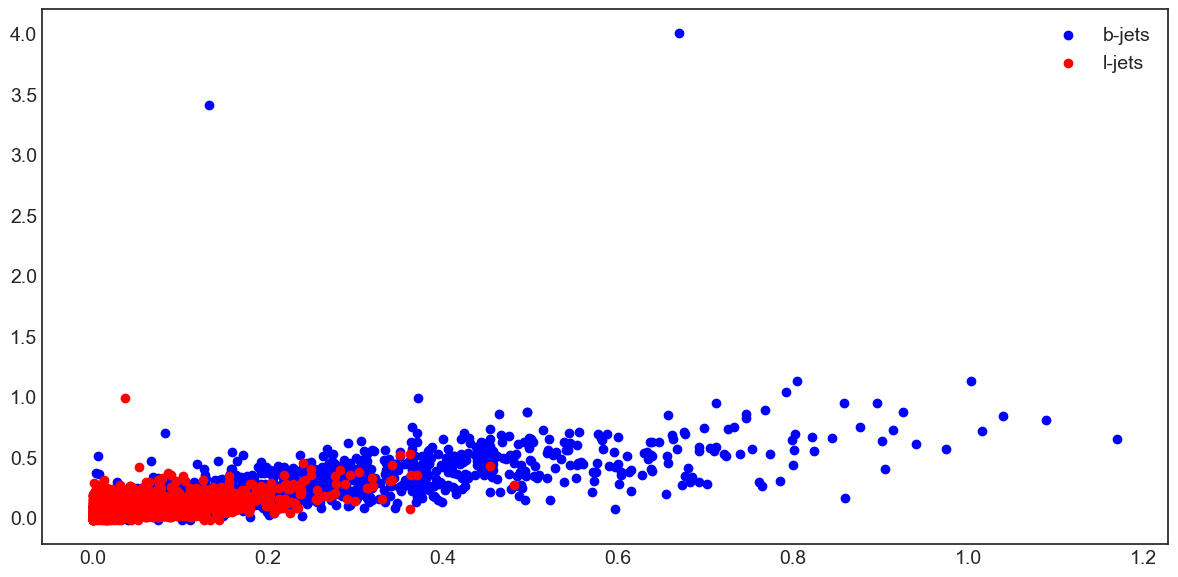

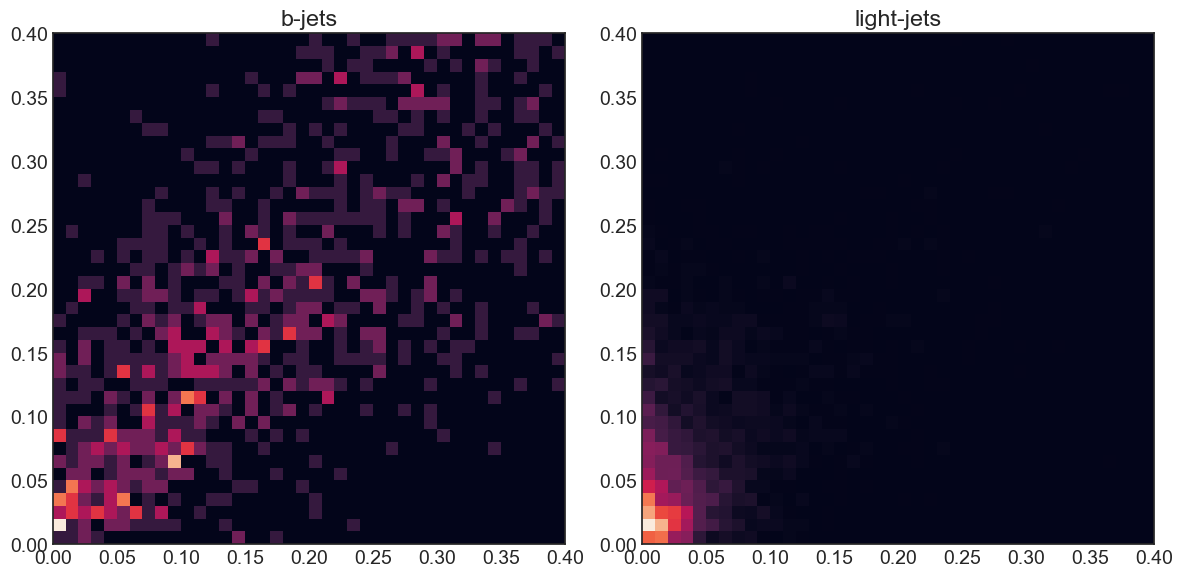

In [10]:
# First we try a scatter plot, to see how the individual events distribute themselves:
fig2, ax2 = plt.subplots(figsize=(12, 6))
scat2_prob_b_vs_bqvjet_bjets = ax2.scatter(prob_b_bjets, bqvjet_bjets, label='b-jets', color='blue')
scat2_prob_b_vs_bqvjet_ljets = ax2.scatter(prob_b_ljets, bqvjet_ljets, label='l-jets', color='red')
ax2.legend(loc='best')
fig2.tight_layout()
#fig2.show()

if SavePlots :
    fig2.savefig('Scatter_prob_b_vs_bqvjet.pdf', dpi=600)


# However, as can be seen in the figure, the overlap between b-jets and light-jets is large,
# and one covers much of the other in a scatter plot, which also does not show the amount of
# statistics in the dense regions. Therefore, we try two separate 2D histograms (zoomed):
fig3, ax3 = plt.subplots(1, 2, figsize=(12, 6))
hist2_prob_b_vs_bqvjet_bjets = ax3[0].hist2d(prob_b_bjets, bqvjet_bjets, bins=[40,40], range=[[0.0, 0.4], [0.0, 0.4]])
hist2_prob_b_vs_bqvjet_ljets = ax3[1].hist2d(prob_b_ljets, bqvjet_ljets, bins=[40,40], range=[[0.0, 0.4], [0.0, 0.4]])
ax3[0].set_title("b-jets")
ax3[1].set_title("light-jets")

fig3.tight_layout()
#fig3.show()

if SavePlots :
    fig3.savefig('Hist2D_prob_b_vs_bqvjet.pdf', dpi=600)

In [11]:
plt.rcParams['font.size'] = 10
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 5
plt.rcParams['axes.labelsize'] = 10

In [12]:
### Compare with Aleph NN-approach from 1990'ies:

In [13]:
bquark=[]
for i in np.arange(len(prob_b)):
    if   (nnbjet[i] > 0.82) : bquark.append(1)
    else : bquark.append(0)

N, accuracy, fracWrong = evaluate(bquark)
print("\nALEPH BJET TAG:")
print("  First number in parenthesis is the estimate, second is the MC truth:")
print("  True-Negative (0,0)  = ", N[0][0])
print("  False-Negative (0,1) = ", N[0][1])
print("  False-Positive (1,0) = ", N[1][0])
print("  True-Positive (1,1)  = ", N[1][1])
print("    Fraction wrong            = ( (0,1) + (1,0) ) / sum = ", fracWrong)
print("    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum = ", accuracy)


ALEPH BJET TAG:
  First number in parenthesis is the estimate, second is the MC truth:
  True-Negative (0,0)  =  3700
  False-Negative (0,1) =  372
  False-Positive (1,0) =  122
  True-Positive (1,1)  =  806
    Fraction wrong            = ( (0,1) + (1,0) ) / sum =  0.0988
    Fraction right (accuracy) = ( (0,0) + (1,1) ) / sum =  0.9012


## Regression
Predict jet energy ("energy") and/or jet angle ("cTheta") from the other variables in the Aleph b-jet dataset

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd

In [15]:
X_train, X_val_test, y_train, y_val_test = train_test_split(pd.DataFrame(data[features]), energy, test_size=0.20)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.50)

In [16]:
model1 = LinearRegression()
model1.fit(X_train, y_train)

LinearRegression()

In [17]:
y_pred1 = model1.predict(X_val)

In [18]:
mean_squared_error(y_pred1, y_val)

38.038085774238716

In [19]:
from sklearn.tree import DecisionTreeRegressor

In [20]:
model2 = DecisionTreeRegressor(max_depth=10, min_samples_split=4, random_state=42)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
print(mean_squared_error(y_pred2, y_test))

39.76663942061931


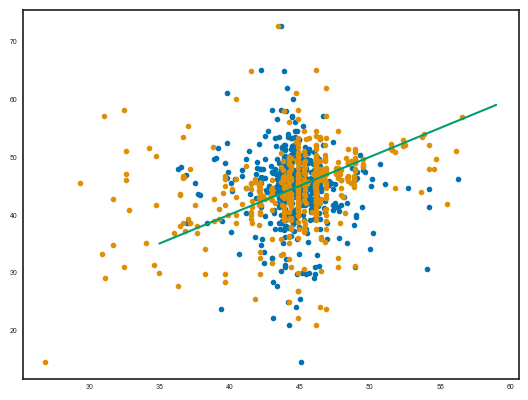

In [21]:
plt.plot(y_pred1, y_test, '.', label='Linear Regression')
plt.plot(y_pred2, y_test, '.', label='Decision Tree Regression')
plt.plot(range(35,60), range(35, 60))

# Nyt forsøg

https://www.tensorflow.org/tutorials/keras/regression

In [22]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.12.0


In [23]:
#sns.pairplot(X_train, diag_kind='kde')

In [24]:
X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
prob_b,4000.0,0.090489,0.138470,0.0000,0.013675,0.03530,0.094950,1.1698
spheri,4000.0,0.361735,0.193448,-1.0000,0.208500,0.33500,0.507325,0.9161
pt2rel,4000.0,0.061975,0.052753,0.0008,0.028000,0.04550,0.076600,0.5719
multip,4000.0,0.363348,0.139236,0.0000,0.261800,0.35085,0.447200,0.8776
bqvjet,4000.0,0.113889,0.150155,-0.0200,0.026975,0.06480,0.143425,4.0000
ptlrel,4000.0,0.033701,0.102654,-0.0003,-0.000300,-0.00030,-0.000300,0.9305


In [25]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

Metal device set to: Apple M1 Pro


2023-05-03 13:49:01.388109: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [26]:
print(normalizer.mean.numpy())

[[0.0904892  0.36173478 0.06197467 0.3633476  0.11388852 0.03370059]]


In [27]:
first = np.array(X_train[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[ 0.15  0.41  0.01  0.18  0.07 -0.  ]]

Normalized: [[ 0.44  0.25 -0.91 -1.31 -0.29 -0.33]]


In [28]:
X_train_normalizer = layers.Normalization(input_shape=[6,], axis=None)
X_train_normalizer.adapt(X_train)

In [29]:
model = tf.keras.Sequential([
    X_train_normalizer, 
    layers.Dense(units=4), # units: dimensionality of the output space.
    layers.Dense(units=2),
    layers.Dense(units=1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 6)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 4)                 28        
                                                                 
 dense_1 (Dense)             (None, 2)                 10        
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 44
Trainable params: 41
Non-trainable params: 3
_________________________________________________________________


In [30]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error')

In [31]:
%%time
history = model.fit(
    X_train, y_train,
    epochs=100,
    verbose=2,
    validation_data=(X_val, y_val))

Epoch 1/100
125/125 - 1s - loss: 41.0751 - val_loss: 38.7555 - 922ms/epoch - 7ms/step
Epoch 2/100
125/125 - 0s - loss: 34.7805 - val_loss: 29.6278 - 465ms/epoch - 4ms/step
Epoch 3/100
125/125 - 0s - loss: 21.9620 - val_loss: 15.1004 - 467ms/epoch - 4ms/step
Epoch 4/100
125/125 - 0s - loss: 12.3399 - val_loss: 12.0875 - 462ms/epoch - 4ms/step
Epoch 5/100
125/125 - 0s - loss: 11.0404 - val_loss: 11.2985 - 463ms/epoch - 4ms/step
Epoch 6/100
125/125 - 0s - loss: 10.3007 - val_loss: 10.5990 - 462ms/epoch - 4ms/step
Epoch 7/100
125/125 - 0s - loss: 9.5971 - val_loss: 9.9400 - 464ms/epoch - 4ms/step
Epoch 8/100
125/125 - 0s - loss: 8.9488 - val_loss: 9.3205 - 463ms/epoch - 4ms/step
Epoch 9/100
125/125 - 0s - loss: 8.3409 - val_loss: 8.7814 - 467ms/epoch - 4ms/step
Epoch 10/100
125/125 - 0s - loss: 7.8387 - val_loss: 8.3018 - 464ms/epoch - 4ms/step
Epoch 11/100
125/125 - 0s - loss: 7.4407 - val_loss: 7.9538 - 458ms/epoch - 4ms/step
Epoch 12/100
125/125 - 0s - loss: 7.1276 - val_loss: 7.6385 - 

Epoch 98/100
125/125 - 0s - loss: 4.0756 - val_loss: 4.5152 - 457ms/epoch - 4ms/step
Epoch 99/100
125/125 - 0s - loss: 4.0825 - val_loss: 4.5112 - 454ms/epoch - 4ms/step
Epoch 100/100
125/125 - 0s - loss: 4.0774 - val_loss: 4.5247 - 458ms/epoch - 4ms/step
CPU times: user 36.6 s, sys: 22.3 s, total: 58.9 s
Wall time: 46.4 s


In [32]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,4.081267,4.505780,95
96,4.076591,4.518224,96
97,4.075609,4.515174,97
98,4.082540,4.511221,98
99,4.077369,4.524673,99


In [33]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

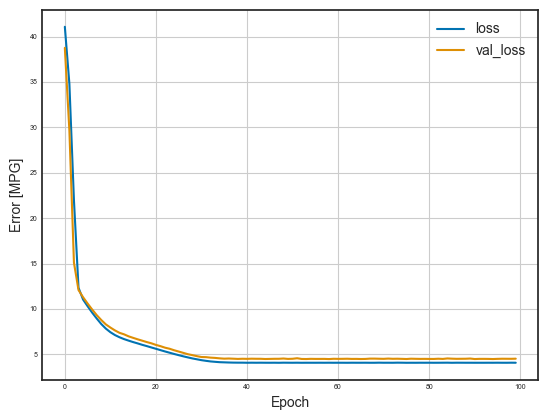

In [34]:
plot_loss(history)

In [35]:
y_pred = model.predict(X_val)
print(mean_squared_error(y_pred, y_test))

16/16 [==============================] - 0s 2ms/step
44.710404114097514


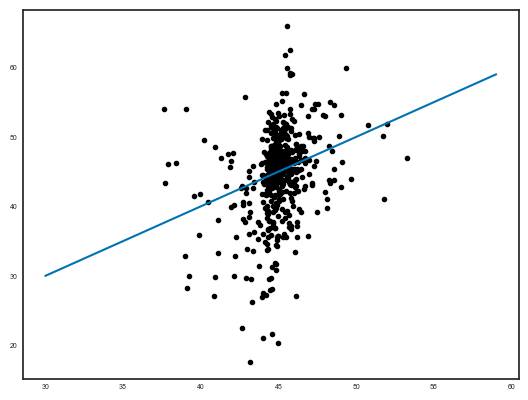

In [36]:
plt.plot(y_pred, y_val, '.', color='black')
plt.plot(range(30, 60), range(30, 60));

In [37]:
model.evaluate(X_train, y_train, verbose=0)

4.071145057678223

# Regression with a deep neural network (DNN)

In [38]:
model_dnn = keras.Sequential([
        normalizer,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
        ])

model_dnn.summary()
model_dnn.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.01),
                 metrics = ['mean_absolute_error'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense_3 (Dense)             (None, 64)                448       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,734
Trainable params: 6,721
Non-trainable params: 13
___________________________________________________

In [39]:
%%time
history_dnn = model_dnn.fit(
    X_train, y_train,
    epochs=30,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[
        tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-3 * 10 ** (-epoch / 30)
        )
    ]
)

Epoch 1/30
125/125 [==============================] - 1s 6ms/step - loss: 26.2641 - mean_absolute_error: 26.2641 - val_loss: 9.4817 - val_mean_absolute_error: 9.4817 - lr: 0.0010
Epoch 2/30
125/125 [==============================] - 1s 5ms/step - loss: 7.7756 - mean_absolute_error: 7.7756 - val_loss: 7.1908 - val_mean_absolute_error: 7.1908 - lr: 9.2612e-04
Epoch 3/30
125/125 [==============================] - 1s 5ms/step - loss: 6.3157 - mean_absolute_error: 6.3157 - val_loss: 6.3315 - val_mean_absolute_error: 6.3315 - lr: 8.5770e-04
Epoch 4/30
125/125 [==============================] - 1s 5ms/step - loss: 5.5548 - mean_absolute_error: 5.5548 - val_loss: 5.4911 - val_mean_absolute_error: 5.4911 - lr: 7.9433e-04
Epoch 5/30
125/125 [==============================] - 1s 5ms/step - loss: 5.0331 - mean_absolute_error: 5.0331 - val_loss: 5.0418 - val_mean_absolute_error: 5.0418 - lr: 7.3564e-04
Epoch 6/30
125/125 [==============================] - 1s 5ms/step - loss: 4.6817 - mean_absolute_

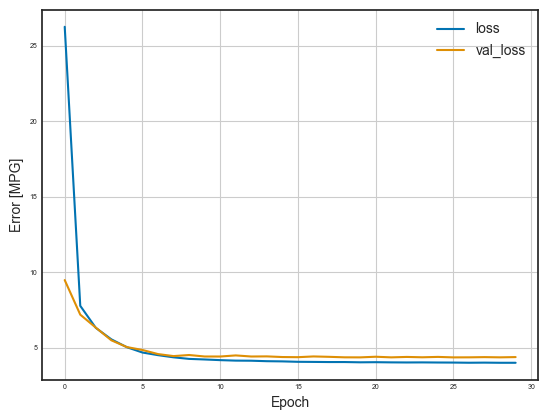

In [40]:
plot_loss(history_dnn)

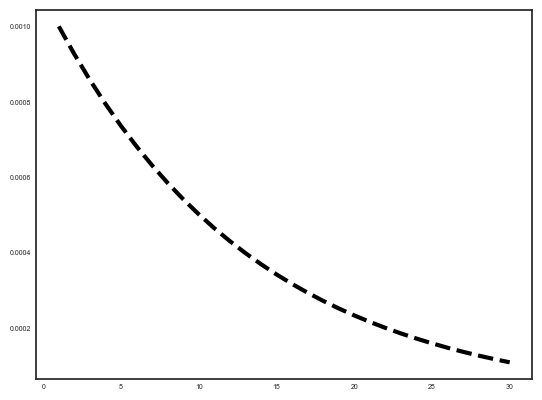

In [41]:
plt.plot(
    np.arange(1, 31), 
    history_dnn.history['lr'], 
    label='Learning rate', color='#000', lw=3, linestyle='--'
)


In [42]:
y_pred_dnn = model_dnn.predict(X_val)
print(mean_squared_error(y_pred_dnn, y_test))

16/16 [==============================] - 0s 3ms/step
45.921681324578934


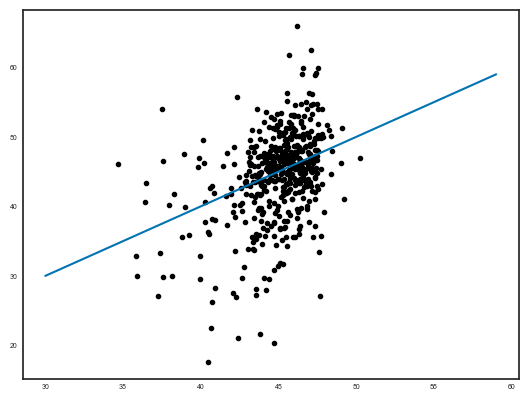

In [43]:
plt.plot(y_pred_dnn, y_val, '.', color='black')
plt.plot(range(30, 60), range(30, 60));